# Policy Generator

+ Tag the traffic trace with the version
+ Ability to compare real vs prediction
+ Ability to generate predictions with variable accuracies
+ Group time periods based on Policy settings
+ Tag each group by decided version 


## 1. Get PD

In [122]:
import time
import requests
import yaml
START_TIME = time.time()
r = requests.get('https://raw.githubusercontent.com/CN-UPB/Pishahang/mvp-thesis/pish-examples/pwm-scripts/descriptors/multiversion/transcoder_mv_policy.yml')
# print(r.text)
PD = yaml.load(r.text, Loader=yaml.FullLoader)

# PD["versions"]

# PD["versions"] = { 
#     'virtual_deployment_units_gpu': {'transcoder-image-1-gpu': {'cost_per_min': 10,
#    'max_data_rate': 3000,
#    'management_overhead': 6}},
#  'virtual_deployment_units_con': {'transcoder-image-1-con': {'cost_per_min': 3,
#    'max_data_rate': 1200,
#    'management_overhead': 6}}}

# for _vm_type_key, _vm_type_value in PD["versions"].items():
#     print(_vm_type_key)    
#     for _vm_version_key, _vm_version_value in _vm_type_value.items():
#         print(_vm_version_key)
#         print(_vm_version_value)
#         print("\n")

# Policy Decision Steps

---



----
### Decision Matrix    

|                    	| Weights 	| Version1 	| Version2 	| Version3 	| Score 	|
|--------------------	|:-------:	|:--------:	|:--------:	|:--------:	|:--------:	|
| Cost (-)           	|    -4    	|     x1   	|    x2    	|    x3    	|    s    	|
| Over Provision (-) 	|    -3   	|     x1   	|    x2    	|    x3    	|    s    	|
| Overhead (-)       	|    -4   	|     x1   	|    x2    	|    x3    	|    s    	|
| Support deviation (+) |    3    	|     x1   	|    x2    	|    x3    	|    s    	|
| Same Version (+)   	|    3    	|     x1   	|    x2    	|    x3    	|    s    	|

In [123]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
_SCORE_MIN, _SCORE_MAX = 1, 5

'''
Find the version with the max supported datarate
'''
def find_max_datarate_version(versions):
    _max_datarate = 0

    for _vm_type_key, _vm_type_value in versions.items():
        # print(_vm_type_key)    

        for _vm_version_key, _vm_version_value in _vm_type_value.items():
            # print(_vm_version_key)
            # print(_vm_version_value["max_data_rate"])

            if _vm_version_value["max_data_rate"] > _max_datarate:
                _max_datarate = _vm_version_value["max_data_rate"]
                _max_datarate_version = { _vm_type_key: { _vm_version_key : _vm_version_value } }

    return _max_datarate_version

'''
Get all the versions that can support the datarate demand
'''
def get_supported_versions(prediction, versions):
    # Iterate versions
    datarate_supported_versions = {}

    for _vm_type_key, _vm_type_value in versions.items():
        # print(_vm_type_key)    

        for _vm_version_key, _vm_version_value in _vm_type_value.items():
            # print(_vm_version_key)
            # print(_vm_version_value["max_data_rate"])
            # print(prediction["mean"])
            if _vm_version_value["max_data_rate"] >= prediction["mean"]:
                # check if key present else add
                if _vm_type_key in datarate_supported_versions:
                    datarate_supported_versions[_vm_type_key][_vm_version_key] = _vm_version_value
                else:
                    datarate_supported_versions[_vm_type_key] = {}
                    datarate_supported_versions[_vm_type_key][_vm_version_key] = _vm_version_value

    if len(datarate_supported_versions) == 0:
        return find_max_datarate_version(versions)
    return datarate_supported_versions

'''
Interpolate data points to a certain range
'''
def interpolate_array(values, min=_SCORE_MIN, max=_SCORE_MAX):
    return np.interp(values, (values.min(), values.max()), (min, max))


'''
Build the decision matrix for a given traffic prediction values 
'''
def build_decision_matrix(prediction, meta, versions):
    _decision_matrix = {}
    for _vm_type_key, _vm_type_value in versions.items():
        for _vm_version_key, _vm_version_value in _vm_type_value.items():
                if _vm_type_key not in _decision_matrix:
                    _decision_matrix[_vm_type_key] = {}
                if _vm_version_key not in _decision_matrix[_vm_type_key]:
                    _decision_matrix[_vm_type_key][_vm_version_key] = {}

                # Cost
                _decision_matrix[_vm_type_key][_vm_version_key]["cost"] = _vm_version_value['cost_per_min']

                # Support deviation
                if _vm_version_value['max_data_rate'] > (prediction['mean'] + prediction['std']):
                    _decision_matrix[_vm_type_key][_vm_version_key]["support_deviation"] = 5
                else:
                    _decision_matrix[_vm_type_key][_vm_version_key]["support_deviation"] = 1

                # Over Provision
                _decision_matrix[_vm_type_key][_vm_version_key]["over_provision"] = int(_vm_version_value['max_data_rate']) - int(prediction['mean'])

                # Same Version
                if meta["current_version"] == _vm_version_key:
                    _decision_matrix[_vm_type_key][_vm_version_key]["same_version"] = 5
                else:
                    _decision_matrix[_vm_type_key][_vm_version_key]["same_version"] = 1

                # Overhead
                _decision_matrix[_vm_type_key][_vm_version_key]["overhead"] = _vm_version_value['management_overhead']

                # Support max datarate
                if _vm_version_value['max_data_rate'] >= (prediction['max']):
                    _decision_matrix[_vm_type_key][_vm_version_key]["support_max"] = 5
                else:
                    _decision_matrix[_vm_type_key][_vm_version_key]["support_max"] = 1

                # Support recent history
                if _vm_version_value['max_data_rate'] >= (meta["recent_history"]["mean"]):
                    _decision_matrix[_vm_type_key][_vm_version_key]["support_recent_history"] = 5
                else:
                    _decision_matrix[_vm_type_key][_vm_version_key]["support_recent_history"] = 1


    decision_matrix_df = pd.DataFrame.from_dict({(i,j): _decision_matrix[i][j] 
                                for i in _decision_matrix.keys() 
                                for j in _decision_matrix[i].keys()},
                                orient='index')

    decision_matrix_df["over_provision"] = interpolate_array(decision_matrix_df["over_provision"])
    decision_matrix_df["cost"] = interpolate_array(decision_matrix_df["cost"])
    decision_matrix_df["overhead"] = interpolate_array(decision_matrix_df["overhead"])

    return decision_matrix_df

'''
Get policy decision given decision matrix and weights
'''
def get_policy_decision(decision_matrix, weights):

    # Negative
    cost = -1 * weights["negative"]["cost"]
    over_provision = -1 * weights["negative"]["over_provision"]
    overhead = -1 * weights["negative"]["overhead"]

    # Positive
    support_deviation = weights["positive"]['support_deviation']
    same_version = weights["positive"]['same_version']

    # WEIGHTS --> [cost, over_provision, overhead, support_deviation, same_version]
    weights_row = [cost, over_provision, overhead, support_deviation, same_version]

    for index_label, row_series in decision_matrix.iterrows():
        _row = np.array([row_series.cost, row_series.over_provision, row_series.overhead, row_series.support_deviation, row_series.same_version])

        decision_matrix.at[index_label , 'score'] = np.dot(np.array(weights_row), _row)

    _version = decision_matrix[decision_matrix.score == decision_matrix.score.max()].index[0]
    return _version

'''
Find the version with least cost
'''
def find_cheapest_version(versions):
    _cost = None

    for _vm_type_key, _vm_type_value in versions.items():
        # print(_vm_type_key)    

        for _vm_version_key, _vm_version_value in _vm_type_value.items():
            # print(_vm_version_key)
            # print(_vm_version_value["max_data_rate"])
            # FIXME: cost_per_min should be int
            if _cost is None:
                _cost = _vm_version_value["cost_per_min"]
                _cost_version = (_vm_type_key, _vm_version_key )

            if int(_vm_version_value["cost_per_min"]) < int(_cost):
                _cost = _vm_version_value["cost_per_min"]
                # _cost_version = { _vm_type_key: { _vm_version_key : _vm_version_value } }
                _cost_version = (_vm_type_key, _vm_version_key )

    return _cost_version


# Run Policy on Dataset
---


In [124]:
import pandas as pd
import numpy as np

LOOK_AHEAD = 5 # Mins

traffic_training_complete = pd.read_csv(r'/plugins/son-mano-traffic-forecast/notebooks/data/dataset_six_traffic.csv', index_col=0)
print(traffic_training_complete.shape)
traffic_training_complete.head(5)

# traffic_training_complete = traffic_training_complete[:720]
traffic_training_complete.head(5)

(11000, 1)


,sent
2020-04-20 22:57:00,1143.842358
2020-04-20 22:58:00,1181.595847
2020-04-20 22:59:00,1158.080520
2020-04-20 23:00:00,1189.863609
2020-04-20 23:01:00,1190.384826


## Random errors to get different accuracies

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe107361a20>,
      dtype=object)

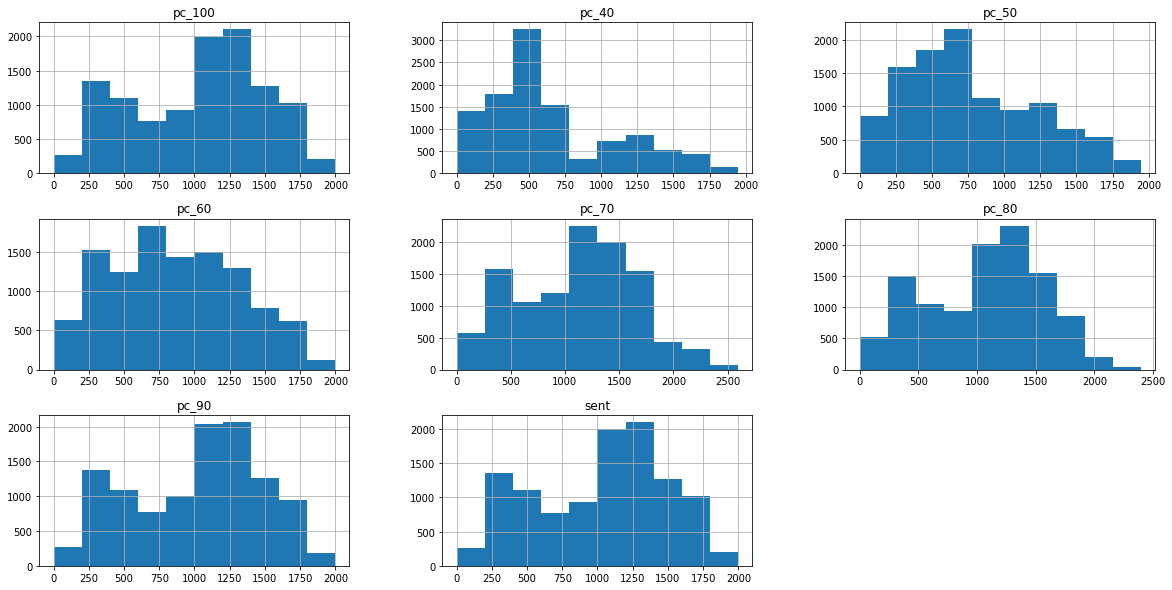

In [125]:
# traffic_training_complete['100%'] = traffic_training_complete['sent']
import random

def get_binomial_samples(size, n=1, p=0.9):
    return np.random.binomial(n, p, size)
  
def get_prob_new_datarate(datarate, p=0.5, accuracy=0.9):
    delta = (1.0 - accuracy) * datarate

    if random.random() < p:
        new_datarate = datarate + delta
    else:
        new_datarate = datarate - delta

    return new_datarate

accuracy_list = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
for _acc in accuracy_list:
    _acc_samples = get_binomial_samples(size=traffic_training_complete.shape[0], n=1, p=_acc)
    traffic_training_complete['pc_{}'.format(int(_acc*100))] = np.where(_acc_samples,
                                            traffic_training_complete['sent'],
                                            get_prob_new_datarate(traffic_training_complete['sent'], accuracy=_acc))

traffic_training_complete
traffic_training_complete.hist(figsize=(20, 10))

In [126]:
traffic_grouped = traffic_training_complete.groupby(
                    np.arange(len(traffic_training_complete))//LOOK_AHEAD).agg(['mean', 'std', 'min', 'max'])

traffic_history = traffic_training_complete.reset_index().copy().drop('index', axis=1)


# traffic_history = traffic_history[:1440] 
# result.index = df.loc[1::2, 'Idx']
print(traffic_grouped.shape[0])
print(traffic_history.shape[0])

traffic_grouped

2200
11000


sent                                            pc_100  \
             mean        std          min          max         mean   
0     1172.753432  20.814400  1143.842358  1190.384826  1172.753432   
1     1218.337667   8.049923  1210.799511  1230.664978  1218.337667   
2     1205.045892  24.457329  1180.014071  1234.143583  1205.045892   
3     1206.115479  19.803907  1177.880182  1229.563959  1206.115479   
4     1212.087369  49.279574  1153.865932  1279.310143  1212.087369   
...           ...        ...          ...          ...          ...   
2195   598.023334  15.170839   582.779777   615.642247   598.023334   
2196   627.008128  30.483275   600.831012   679.375834   627.008128   
2197   725.869675  25.513858   702.407705   762.322983   725.869675   
2198   718.561680  12.725238   697.811885   729.156559   718.561680   
2199   708.203283  20.984157   672.663927   726.260193   708.203283   

                                                 pc_90             ...  \
            std          min          max         mean        std  ...   
0     20.814400  1143.842358  1190.384826  1172.753432  20.814400  ...   
1      8.049923  1210.799511  1230.664978  1193.724367  48.325297  ...   
2     24.457329  1180.014071  1234.143583  1205.045892  24.457329  ...   
3     19.803907  1177.880182  1229.563959  1206.115479  19.803907  ...   
4     49.279574  1153.865932  1279.310143  1161.873666  40.884609  ...   
...         ...          ...          ...          ...        ...  ...   
2195  15.170839   582.779777   615.642247   586.367739  36.791313  ...   
2196  30.483275   600.831012   679.375834   614.991508  49.372330  ...   
2197  25.513858   702.407705   762.322983   725.869675  25.513858  ...   
2198  12.725238   697.811885   729.156559   675.679277  45.654704  ...   
2199  20.984157   672.663927   726.260193   693.678079  28.974848  ...   

           pc_60                     pc_50                          \
             min          max         mean         std         min   
0     686.305415  1190.384826  1053.767071  257.162041  594.931804   
1     726.479707  1230.664978   973.153334  328.822087  610.589176   
2     740.486150  1226.278524  1082.418039  263.204923  613.139262   
3     731.769077  1229.563959   963.890925  327.634409  601.315202   
4     692.319559  1231.374967   728.110776  276.439330  576.932966   
...          ...          ...          ...         ...         ...   
2195  355.206160   586.899011   357.289645  126.208943  293.449505   
2196  360.498607   679.375834   505.505244  185.780427  300.415506   
2197  421.444623   457.393790   649.637376  150.865751  381.161492   
2198  430.557226   729.156559   500.821566  188.995866  359.765857   
2199  425.798267   672.663927   568.858533  201.566583  336.331964   

                        pc_40                                       
              max        mean         std         min          max  
0     1190.384826  749.146089  381.688708  463.232208  1189.863609  
1     1217.095869  926.362310  401.489168  484.779849  1230.664978  
2     1234.143583  629.171780  333.902395  472.005629  1226.278524  
3     1229.563959  628.800007  330.356887  471.152073  1219.615128  
4     1220.670913  631.315457  330.043295  461.546373  1220.670913  
...           ...         ...         ...         ...          ...  
2195   582.779777  453.718384  194.978851  234.759604   612.785370  
2196   679.375834  480.977114  218.311295  240.332405   679.375834  
2197   739.008148  290.347870   10.205543  280.963082   304.929193  
2198   717.595377  373.768477  193.354414  279.124754   719.531713  
2199   726.260193  455.592190  239.690639  269.065571   726.260193  

[2200 rows x 32 columns]

## Run evaluation on different datasets

In [127]:
# Run Policy on Dataset
# WEIGHTS --> [cost, over_provision, overhead, support_deviation, same_version]
WEIGHTS = {
    "negative": {
      "cost": 5,
      "over_provision": 2,
      "overhead": 3
    },
    "positive": {
      "support_deviation": 1,
      "same_version": 1,
      "support_max": 1,
      "support_recent_history": 1
    }
  }

switch_counter = {"pc_{}".format(int(_acc*100)):0 for _acc in accuracy_list }
switch_counter['history'] = 0

_results = {}
for _acc in accuracy_list:
   _results["pc_{}".format(int(_acc*100))] = traffic_grouped["pc_{}".format(int(_acc*100))].copy()
   # traffic_policy_test.plot()

   # iterate over the dataframe row by row and set version
   meta = { 
      "current_version": "transcoder-image-1-vm",
      "current_version_history": "transcoder-image-1-vm",
      "recent_history": None
   }


   with open("output_debug.log", "w") as f:
      for index_label, row_series in _results["pc_{}".format(int(_acc*100))].iterrows():
         if meta["recent_history"] is None:
            meta["recent_history"] = row_series

         supported_versions = get_supported_versions(prediction=row_series, versions=PD["versions"])

         decision_matrix_df = build_decision_matrix(prediction=row_series, meta=meta, versions=supported_versions)

         _selected_version = ":".join(get_policy_decision(decision_matrix_df, WEIGHTS))
         _results["pc_{}".format(int(_acc*100))].at[index_label , 'policy'] = _selected_version
         
         if not _selected_version.split(":")[1] == meta["current_version"]:
            switch_counter["pc_{}".format(int(_acc*100))] += 1

         f.write("\nrecent_history\n")
         f.write(str(meta["recent_history"]))
         f.write("\nForecast\n")
         f.write(str(row_series))

         meta = {
            "current_version": _selected_version.split(":")[1],
            "recent_history": row_series
         } 


         f.write("\n\n_selected_version\n")
         f.write(_selected_version)
         
         f.write("\n\n")
         f.write(str(decision_matrix_df))
         f.write("\n\n")
         # print(row_series)
      # print(decision_matrix_df)
      # print("\n\n")

# _results   
print(switch_counter)
# traffic_policy_test.to_csv('./data/{}m_policy_decisions_dataset_six_traffic.csv'.format(LOOK_AHEAD))
# traffic_policy_test.head(10)

{'pc_100': 45, 'pc_90': 49, 'pc_80': 90, 'pc_70': 122, 'pc_60': 279, 'pc_50': 243, 'pc_40': 165, 'history': 0}


In [128]:
meta = { 
   "current_version_history": "transcoder-image-1-vm",
   "recent_history": None
}

row_counter = 0

for index_label, row_series in traffic_history.iterrows():
   if meta["recent_history"] is None:
      meta["recent_history"] = row_series['sent']

   supported_versions_history = get_supported_versions(prediction={"mean": meta['recent_history']}, versions=PD["versions"])

   _selected_version_history = ":".join(find_cheapest_version(versions=supported_versions_history))
   traffic_history.at[index_label , 'history'] = _selected_version_history

   if not _selected_version_history.split(":")[1] == meta["current_version_history"]:
      switch_counter["history"] += 1

   meta = {
      "current_version_history": _selected_version_history.split(":")[1],
      "recent_history": row_series['sent']
   } 

   row_counter += 1

# print(switch_counter)


## Merge Data

In [129]:
# pd.concat([traffic_policy_test]*2, ignore_index=True)
final_decision_dataset = _results["pc_100"].iloc[np.repeat(np.arange(len(_results["pc_100"])), 5)].reset_index().drop('index', axis=1)
final_decision_dataset['history'] = traffic_history['history']

print("Switch Stats")
print(switch_counter)

print("\nPolicy")
print(final_decision_dataset['policy'].value_counts())

print("\nHistory")
print(final_decision_dataset['history'].value_counts())

final_decision_dataset.to_csv('./data/{}m_policy_decisions_dataset_six_traffic.csv'.format(LOOK_AHEAD))
print(final_decision_dataset.shape)
final_decision_dataset.head(10)


Switch Stats
{'pc_100': 45, 'pc_90': 49, 'pc_80': 90, 'pc_70': 122, 'pc_60': 279, 'pc_50': 243, 'pc_40': 165, 'history': 625}

Policy
virtual_deployment_units_con:transcoder-image-1-con    6350
virtual_deployment_units_gpu:transcoder-image-1-gpu    4650
Name: policy, dtype: int64

History
virtual_deployment_units_gpu:transcoder-image-1-gpu    4595
virtual_deployment_units_con:transcoder-image-1-con    3692
virtual_deployment_units_vm:transcoder-image-1-vm      2713
Name: history, dtype: int64
(11000, 6)


,mean,std,min,max,policy,history
0,1172.753432,20.814400,1143.842358,1190.384826,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...
1,1172.753432,20.814400,1143.842358,1190.384826,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...
2,1172.753432,20.814400,1143.842358,1190.384826,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...
3,1172.753432,20.814400,1143.842358,1190.384826,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...
4,1172.753432,20.814400,1143.842358,1190.384826,virtual_deployment_units_con:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...
5,1218.337667,8.049923,1210.799511,1230.664978,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_con:transcoder-image-...
6,1218.337667,8.049923,1210.799511,1230.664978,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...
7,1218.337667,8.049923,1210.799511,1230.664978,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...
8,1218.337667,8.049923,1210.799511,1230.664978,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...
9,1218.337667,8.049923,1210.799511,1230.664978,virtual_deployment_units_gpu:transcoder-image-...,virtual_deployment_units_gpu:transcoder-image-...


In [130]:
# https://stackoverflow.com/questions/53766397/how-to-center-the-grid-of-a-plot-on-scatter-points
# https://stackoverflow.com/questions/47684652/how-to-customize-marker-colors-and-shapes-in-scatter-plot
DRAW_SCATTER = False
if DRAW_SCATTER:
    from matplotlib import pyplot as plt 

    markers = ["s" , "s" , "o" , "v" , "^" , "<", ">"]
    colors = ['r','g','b','c','m', 'y', 'k']

    x = final_decision_dataset.index
    y = [final_decision_dataset.policy, final_decision_dataset.history]
    labels = ['policy', 'history']

    # traffic_policy_test.reset_index().plot.scatter(figsize=(20,10), fontsize=20, x=x, y=y, marker="v")

    fig, ax = plt.subplots(figsize=(200,2))
    for i in range(2): #for each of the 7 features 
        mi = markers[i] #marker for ith feature 
        xi = x #x array for ith feature .. here is where you would generalize      different x for every feature
        yi = y[i] #y array for ith feature 
        ci = colors[i] #color for ith feature 
        ax.scatter(xi,yi, marker=mi, color=ci, s=49, label=labels[i])

    ax.set_yticks(np.arange(3))
    ax.set_yticks(np.arange(3+1)-0.5, minor=True)

    ax.set_xticks(np.arange(len(y[0])))
    ax.set_xticks(np.arange(len(y[0])+1)-0.5, minor=True)

    ax.grid(True, which="minor")
    ax.set_aspect("equal")
    plt.legend(loc="upper left")
    plt.show()



In [131]:
print("Took: {}".format(time.time() - START_TIME))

Took: 277.1722948551178
